In [36]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


#Leggo il file in output di chatGPT
chatGPTOutptDEFAULT_PARAMETERS = pd.read_csv('../Query/output/outputChatGPT_DEFAULT_PARAMETERS.csv')
outputChatGPT_HIGH_TOP_P = pd.read_csv('../Query/output/outputChatGPT_HIGH_TOP_P.csv')
outputChatGPT_HIGH_TEMPERATURE = pd.read_csv('../Query/output/outputChatGPT_HIGH_TEMPERATURE.csv')


#Leggo le annotazioni parsate degli annotatori
annotazioni = pd.read_csv('../Annotations/Annotations_checked.csv')

In [37]:
print(outputChatGPT_HIGH_TOP_P.columns.tolist())
print(outputChatGPT_HIGH_TEMPERATURE.columns.tolist())
print(chatGPTOutptDEFAULT_PARAMETERS.columns.tolist())


['id', 'title', 'label', 'annotator', 'Q1.1', 'Q1.2', 'Q1.3', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q1.7.1', 'Q1.7.1.2', 'Q2.8', 'Q2.9.1', 'Q2.9.2', 'Q2.10', 'Problem']
['id', 'title', 'label', 'annotator', 'Q1.1', 'Q1.2', 'Q1.3', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q1.7.1', 'Q1.7.1.2', 'Q2.8', 'Q2.9.1', 'Q2.9.2', 'Q2.10', 'Problem']
['id', 'title', 'label', 'annotator', 'Q1.1', 'Q1.2', 'Q1.3', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q1.7.1', 'Q1.7.1.2', 'Q2.8', 'Q2.9.1', 'Q2.9.2', 'Q2.10', 'Problem']


In [38]:
def clean_dataframe(df):
    # Funzione per convertire i valori
    def convert_values(value):
        if isinstance(value, str):
            # Rimuovi parentesi quadre
            value = value.strip("[]")
            # Sostituisci virgole con punti e virgola
            value = value.replace(",", ";")
            value = value.replace("'", "")
            value = value.replace(" ", "")
            value = value.replace("/n", "")



        return value

    # Applica la funzione alla colonna
    df['Q1.7.1'] = df['Q1.7.1'].apply(convert_values)
    df['Q1.3'] = df['Q1.3'].apply(convert_values)

    # Converto le colonne numeriche in INT
    columns_to_convert = ['Q1.1', 'Q1.2', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q2.8', 'Q2.9.1', 'Q2.10']
    # Sostituisco i NaN in -1
    df[columns_to_convert] = df[columns_to_convert].fillna(-1)
    # Applico il cast
    for col in columns_to_convert:
        df[columns_to_convert] = df[columns_to_convert].astype(int)

    # Faccio one hot delle colonne a valore multuiplo (Q1.3, 1.7.1)
    # Creiamo una nuova colonna per ciascun valore unico trovato nella colonna "Q1.3"
    listQ_1_3 = [1,2,3,4,5,6,7,8,9]
    for value in listQ_1_3:
        df[f'Q1.3_{value}'] = 0

    # Creiamo una nuova colonna per ciascun valore unico trovato nella colonna "Q1.7"
    listQ1_7_1 = [0,1,2,3,4,5,6,7,8,9,10,11,12]
    for value in listQ1_7_1:
        df[f'Q1.7.1_{value}'] = 0

    # Assegniamo 1 a ciascuna colonna appena creata se il valore corrisponde a quello nella colonna "Q1.3"
    for idx, row in df.iterrows():
        values = str(row['Q1.3']).split(';')  # Convertiamo in stringa prima di fare lo split
        for value in values:
            df.at[idx, f'Q1.3_{value}'] = 1

    # Assegniamo 1 a ciascuna colonna appena creata se il valore corrisponde a quello nella colonna "Q1.7.1"
    for idx, row in df.iterrows():
        values = str(row['Q1.7.1']).split(';')  # Convertiamo in stringa prima di fare lo split
        for value in values:
            df.at[idx, f'Q1.7.1_{value}'] = 1

    # Elimino le colonne ridondanti
    columns_to_drop = ['Q1.3', 'Q1.7.1', 'Q1.7.1_-1', 'Problem', 'Q1.7.1_']
    for col in columns_to_drop:
        try:
            df.drop(col, axis=1, inplace=True)
        except KeyError:
            # Ignora se la colonna non esiste nel DataFrame
            pass

    # Trasformo le date in oggetti datetime
    def Q2_92(df, column):
        try:
            df[column] = pd.to_datetime(df[column], format='%d/%m/%Y')
        except Exception as e:
            df[column] = -1

    Q2_92(df, 'Q2.9.2')

    return df

# Utilizzo della funzione
outputChatGPT_HIGH_TOP_P = clean_dataframe(outputChatGPT_HIGH_TOP_P)
outputChatGPT_HIGH_TEMPERATURE = clean_dataframe(outputChatGPT_HIGH_TEMPERATURE)
chatGPTOutptDEFAULT_PARAMETERS = clean_dataframe(chatGPTOutptDEFAULT_PARAMETERS)

In [39]:
print(outputChatGPT_HIGH_TOP_P.columns.tolist())
print(outputChatGPT_HIGH_TEMPERATURE.columns.tolist())
print(chatGPTOutptDEFAULT_PARAMETERS.columns.tolist())


['id', 'title', 'label', 'annotator', 'Q1.1', 'Q1.2', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q1.7.1.2', 'Q2.8', 'Q2.9.1', 'Q2.9.2', 'Q2.10', 'Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9', 'Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12']
['id', 'title', 'label', 'annotator', 'Q1.1', 'Q1.2', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q1.7.1.2', 'Q2.8', 'Q2.9.1', 'Q2.9.2', 'Q2.10', 'Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9', 'Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12']
['id', 'title', 'label', 'annotator', 'Q1.1', 'Q1.2', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q1.7.1.2', 'Q2.8', 'Q2.9.1', 'Q2.9.2', 'Q2.10', 'Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7

In [40]:
# Faccio il merge dei due csv

frames = [annotazioni, outputChatGPT_HIGH_TOP_P,outputChatGPT_HIGH_TEMPERATURE, chatGPTOutptDEFAULT_PARAMETERS]

df = pd.concat(frames)

df

,id,title,label,annotator,Q1.1,Q1.2,Q1.3.1,Q1.4,Q1.5,Q1.6,...,Q1.7.1_3,Q1.7.1_4,Q1.7.1_5,Q1.7.1_6,Q1.7.1_7,Q1.7.1_8,Q1.7.1_9,Q1.7.1_10,Q1.7.1_11,Q1.7.1_12
0,18d71db7-f362-46fa-953e-d8353c7f7232,Coronavirus| nuove regole: al tavolo al ristor...,Group 2,Manuel,1,2,-1,2,4,4,...,0,0,0,0,0,0,0,0,0,0
1,18d71db7-f362-46fa-953e-d8353c7f7232,Coronavirus| nuove regole: al tavolo al ristor...,Group 2,Angelo,1,3,1,1,4,4,...,0,0,0,0,0,0,0,0,0,0
2,3ca70f03-38f3-4a7b-bdd3-f012b22e0c7e,Israele: Lapid| ostacoli ma fiducioso su nuovo...,Group 2,Manuel,1,4,-1,2,4,4,...,0,0,0,0,0,0,0,0,0,0
3,34b92f4c-32db-454c-a369-ca2032443f6c,Le borsette fatte a 3 euro l'ora vendute a 820...,Group 1,Manuel,2,3,-1,1,3,2,...,0,0,0,0,0,0,0,0,1,0
4,34b92f4c-32db-454c-a369-ca2032443f6c,Le borsette fatte a 3 euro l'ora vendute a 820...,Group 1,Marinella,2,3,-1,1,3,2,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,d4271fe2-7141-4158-88ff-47c78609f774,Il countdown: cosa accadrà tra poco a questi t...,Group 2,GPT_DEFAULT_PARAMETERS,3,4,2,2,4,3,...,0,0,0,0,0,0,0,0,0,0
6,48c6fea6-52c1-46e6-b53c-68fbe9d72d4b,Incidente mortale A14 ad Ancona Nord: muore mo...,Group 1,GPT_DEFAULT_PARAMETERS,1,4,2,2,4,3,...,0,0,0,0,0,0,0,0,0,0
7,83357b52-7b02-4cf2-8d9d-888dcc85ac0f,IL TAR LAZIO ORDINA AL MINISTERO DELLA SALUTE ...,Group 1,GPT_DEFAULT_PARAMETERS,3,4,2,2,4,3,...,0,0,0,0,0,0,0,0,0,0
8,3069108e-db2e-49cf-a1d8-80b60a702953,"Tra aperitivi digitali e delivery, la pandemia...",Group 1,GPT_DEFAULT_PARAMETERS,3,4,2,2,4,3,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# Per ciascun articolo condiviso, calcola il coefficiente Kappa di Cohen
def getKappa (annotator_1, annotator_2):
# Inizializza una lista per memorizzare i coefficienti Kappa di Cohen
    kappa_scores = []

    articles = set(df[df['annotator'] == annotator_1]['id']).intersection(
    set(df[df['annotator'] == annotator_2]['id']))
    for article_id in articles:
        annotator1 = df[(df['id'] == article_id) & (df['annotator'] == annotator_1)][['Q1.1', 'Q1.2', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q2.8', 'Q2.9.1', 'Q2.10', 'Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9', 'Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12']]
        annotator2 = df[(df['id'] == article_id) & (df['annotator'] == annotator_2)][['Q1.1', 'Q1.2', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q2.8', 'Q2.9.1', 'Q2.10', 'Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9', 'Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12']]

        # Converti i valori in numeri interi o float
        annotator1 = annotator1.astype(float)
        annotator2 = annotator2.astype(float)
        
        # Calcola il coefficiente Kappa di Cohen per ciascuna coppia di annotatori
        k = cohen_kappa_score(annotator1.values.flatten(), annotator2.values.flatten())
        kappa_scores.append(k)
    if (len(kappa_scores) > 0):
        mean_kappa = sum(kappa_scores) / len(kappa_scores)
    else:
        print('Non ci sono annotazioni in comune tra gli annotatori ' + str(annotator_1) + ' e ' + str(annotator_1))
        return ()
    print ('Il K tra ' + str(annotator_1) +' e ' + str(annotator_2) +' è  di: '  + str(mean_kappa))
    return mean_kappa

out = getKappa('Manuel', 'Angelo')
out = getKappa('Manuel', 'Marinella')
out = getKappa('Angelo', 'Marinella')
print ('------------------------------------------')
out = getKappa('GPT_DEFAULT_PARAMETERS', 'Marinella')
out = getKappa('GPT_DEFAULT_PARAMETERS', 'Angelo')
out = getKappa('GPT_DEFAULT_PARAMETERS', 'Manuel')
print ('------------------------------------------')
out = getKappa('GPT_HIGH_TEMPERATURE', 'Marinella')
out = getKappa('GPT_HIGH_TEMPERATURE', 'Angelo')
out = getKappa('GPT_HIGH_TEMPERATURE', 'Manuel')
print ('------------------------------------------')
out = getKappa('GPT_HIGH_TOP_P', 'Marinella')
out = getKappa('GPT_HIGH_TOP_P', 'Angelo')
out = getKappa('GPT_HIGH_TOP_P', 'Manuel')

Il K tra Manuel e Angelo è  di: 0.8619795552450442
Il K tra Manuel e Marinella è  di: 0.8723454045098787
Il K tra Angelo e Marinella è  di: 0.8635265076197409
------------------------------------------
Il K tra GPT_DEFAULT_PARAMETERS e Marinella è  di: 0.6059605222439721
Il K tra GPT_DEFAULT_PARAMETERS e Angelo è  di: 0.688720817494689
Il K tra GPT_DEFAULT_PARAMETERS e Manuel è  di: 0.65974931437417
------------------------------------------
Il K tra GPT_HIGH_TEMPERATURE e Marinella è  di: 0.6209414115967844
Il K tra GPT_HIGH_TEMPERATURE e Angelo è  di: 0.708354790926068
Il K tra GPT_HIGH_TEMPERATURE e Manuel è  di: 0.6710658991420964
------------------------------------------
Il K tra GPT_HIGH_TOP_P e Marinella è  di: 0.6102209035583155
Il K tra GPT_HIGH_TOP_P e Angelo è  di: 0.683474103815968
Il K tra GPT_HIGH_TOP_P e Manuel è  di: 0.66670378448165


In [42]:
def calculate_metrics_sklearn(annotator_1, annotator_2):
    y_true = []
    y_pred = []

    articles = set(df[df['annotator'] == annotator_1]['id']).intersection(
    set(df[df['annotator'] == annotator_2]['id']))
    
    for article_id in articles:
        annotator1 = df[(df['id'] == article_id) & (df['annotator'] == annotator_1)][['Q1.1', 'Q1.2', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q2.8', 'Q2.9.1', 'Q2.10', 'Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9', 'Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12']]
        annotator2 = df[(df['id'] == article_id) & (df['annotator'] == annotator_2)][['Q1.1', 'Q1.2', 'Q1.3.1', 'Q1.4', 'Q1.5', 'Q1.6', 'Q1.7', 'Q2.8', 'Q2.9.1', 'Q2.10', 'Q1.3_1', 'Q1.3_2', 'Q1.3_3', 'Q1.3_4', 'Q1.3_5', 'Q1.3_6', 'Q1.3_7', 'Q1.3_8', 'Q1.3_9', 'Q1.7.1_0', 'Q1.7.1_1', 'Q1.7.1_2', 'Q1.7.1_3', 'Q1.7.1_4', 'Q1.7.1_5', 'Q1.7.1_6', 'Q1.7.1_7', 'Q1.7.1_8', 'Q1.7.1_9', 'Q1.7.1_10', 'Q1.7.1_11', 'Q1.7.1_12']]
        
        annotator1 = annotator1.astype(str)
        annotator2 = annotator2.astype(str)
        
        for col in annotator1.columns:
            annotations_1 = annotator1[col].values.flatten()
            annotations_2 = annotator2[col].values.flatten()
            for ann_1, ann_2 in zip(annotations_1, annotations_2):
                y_true.append(ann_1)
                y_pred.append(ann_2)

    print('Le statistiche tra ' + str(annotator_1) + ' e ' + str(annotator_2) + ' sono: ')

    print('Accuracy: ' + str(accuracy_score(y_true, y_pred)))
    print('Precision micro: ' + str(precision_score(y_true, y_pred, average='micro', zero_division=0)))
    print('Precision macro: ' + str(precision_score(y_true, y_pred, average='macro', zero_division=0)))
    print('Precision weighted: ' + str(precision_score(y_true, y_pred, average='weighted', zero_division=0)))

    print('Recall micro: ' + str(recall_score(y_true, y_pred, average='micro', zero_division=0)))
    print('Recall macro: ' + str(recall_score(y_true, y_pred, average='macro', zero_division=0)))
    print('Recall weighted: ' + str(recall_score(y_true, y_pred, average='weighted', zero_division=0)))

    print('F1 micro: ' + str(f1_score(y_true, y_pred, average='micro', zero_division=0)))
    print('F1 macro: ' + str(f1_score(y_true, y_pred, average='macro', zero_division=0)))
    print('F1 weighted: ' + str(f1_score(y_true, y_pred, average='weighted', zero_division=0)))
    print('\n')
    return (0)

calculate_metrics_sklearn('Manuel','GPT_DEFAULT_PARAMETERS')
calculate_metrics_sklearn('Angelo','GPT_DEFAULT_PARAMETERS')
calculate_metrics_sklearn('Marinella','GPT_DEFAULT_PARAMETERS')

calculate_metrics_sklearn('Manuel','GPT_HIGH_TEMPERATURE')
calculate_metrics_sklearn('Angelo','GPT_HIGH_TEMPERATURE')
calculate_metrics_sklearn('Marinella','GPT_HIGH_TEMPERATURE')

calculate_metrics_sklearn('Manuel','GPT_HIGH_TOP_P')
calculate_metrics_sklearn('Angelo','GPT_HIGH_TOP_P')
calculate_metrics_sklearn('Marinella','GPT_HIGH_TOP_P')


Le statistiche tra Manuel e GPT_DEFAULT_PARAMETERS sono: 
Accuracy: 0.8046875
Precision micro: 0.8046875
Precision macro: 0.46567204102233056
Precision weighted: 0.8080699215869331
Recall micro: 0.8046875
Recall macro: 0.5090837212077813
Recall weighted: 0.8046875
F1 micro: 0.8046875
F1 macro: 0.46189177686919153
F1 weighted: 0.793764213196652


Le statistiche tra Angelo e GPT_DEFAULT_PARAMETERS sono: 
Accuracy: 0.825
Precision micro: 0.825
Precision macro: 0.5732184269486262
Precision weighted: 0.8224767353877599
Recall micro: 0.825
Recall macro: 0.6071873670883572
Recall weighted: 0.825
F1 micro: 0.825
F1 macro: 0.5726566836541261
F1 weighted: 0.8162542494831498


Le statistiche tra Marinella e GPT_DEFAULT_PARAMETERS sono: 
Accuracy: 0.7760416666666666
Precision micro: 0.7760416666666666
Precision macro: 0.47969861213763654
Precision weighted: 0.7733732138457748
Recall micro: 0.7760416666666666
Recall macro: 0.5242141696687151
Recall weighted: 0.7760416666666666
F1 micro: 0.776041666

0

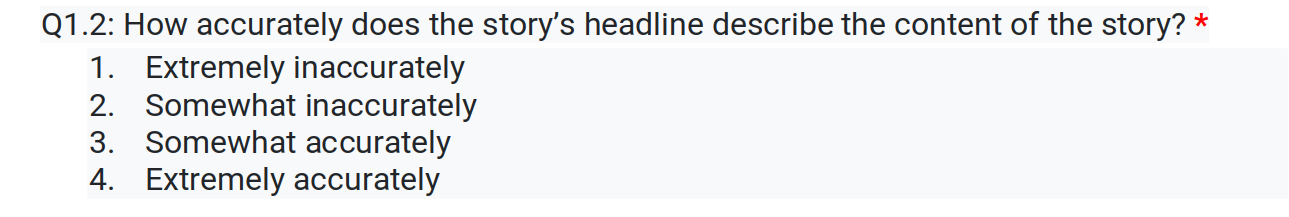

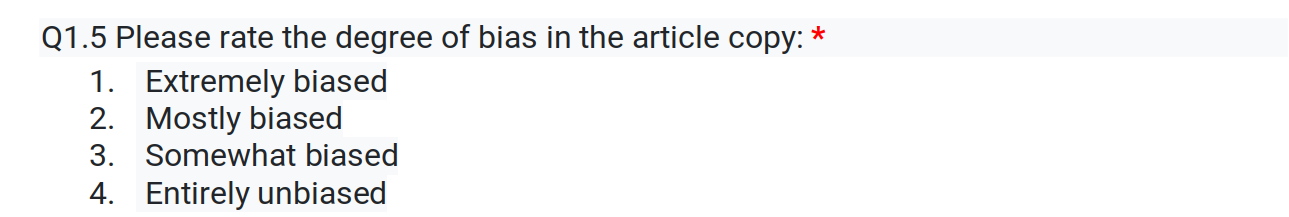

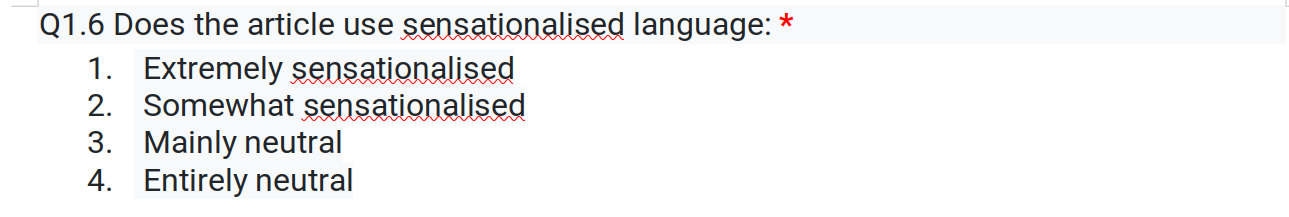

Manuel VS GPT_DEFAULT_PARAMETERS


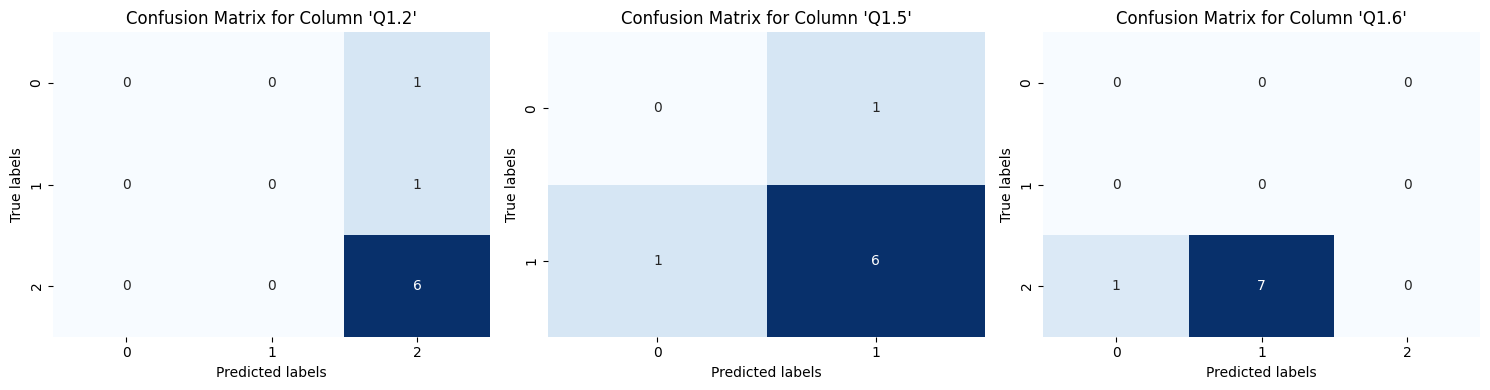

Angelo VS GPT_DEFAULT_PARAMETERS


/home/john/Progetti/ChatGPTAsAnnotator/ChatGPTAsAnnotator/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


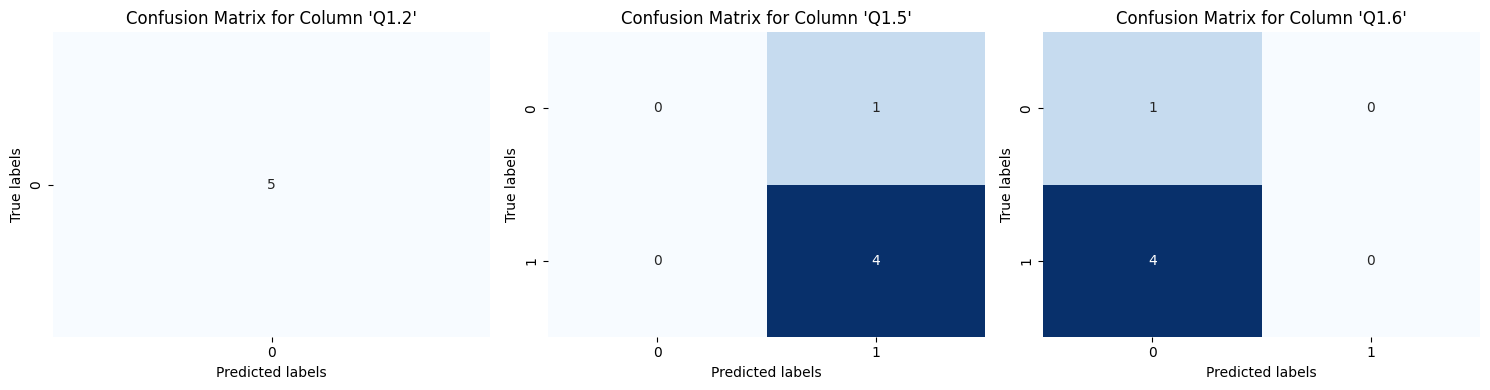

Marinella VS GPT_DEFAULT_PARAMETERS


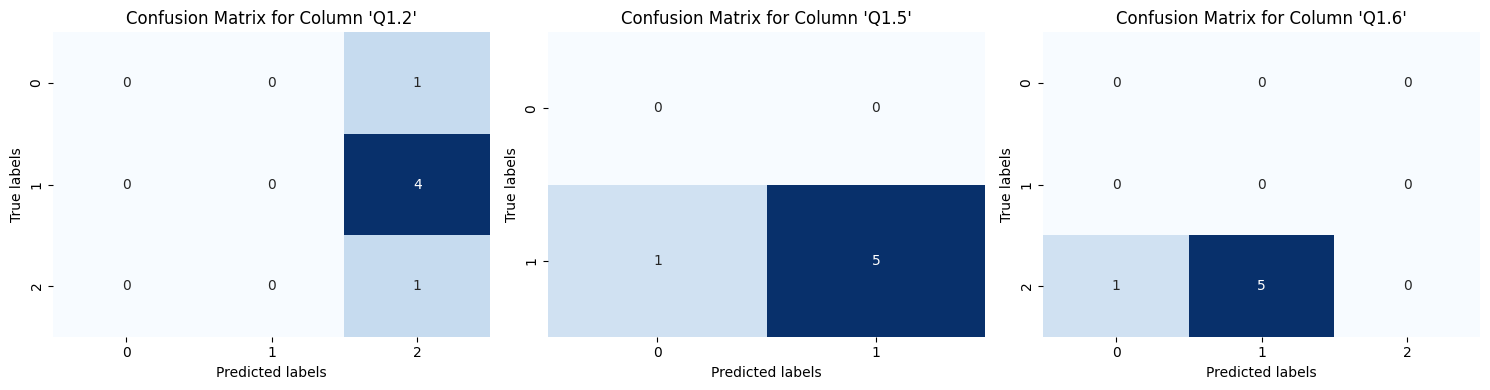

In [57]:
def calculate_confusion_matrix(annotator_1, annotator_2, columns):
    confusion_matrices = {}
    
    for column in columns:
        y_true = []
        y_pred = []

        articles = set(df[df['annotator'] == annotator_1]['id']).intersection(
            set(df[df['annotator'] == annotator_2]['id']))

        for article_id in articles:
            annotator1 = df[(df['id'] == article_id) & (df['annotator'] == annotator_1)][[column]]
            annotator2 = df[(df['id'] == article_id) & (df['annotator'] == annotator_2)][[column]]

            annotator1 = annotator1.astype(str)
            annotator2 = annotator2.astype(str)

            for col in annotator1.columns:
                annotations_1 = annotator1[col].values.flatten()
                annotations_2 = annotator2[col].values.flatten()
                for ann_1, ann_2 in zip(annotations_1, annotations_2):
                    y_true.append(ann_1)
                    y_pred.append(ann_2)

        confusion_matrices[column] = confusion_matrix(y_true, y_pred)
    plot_confusion_matrices(confusion_matrices)
    return 0

def plot_confusion_matrices(conf_matrices):
    num_cols = len(conf_matrices)
    fig, axes = plt.subplots(1, num_cols, figsize=(5*num_cols, 4))

    for i, (column, conf_matrix) in enumerate(conf_matrices.items()):
        sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[i])
        axes[i].set_xlabel("Predicted labels")
        axes[i].set_ylabel("True labels")
        axes[i].set_title(f"Confusion Matrix for Column '{column}'")

    plt.tight_layout()
    plt.show()

columns_to_consider = ['Q1.2', 'Q1.5', 'Q1.6']
print('Manuel VS GPT_DEFAULT_PARAMETERS')
conf_matrices = calculate_confusion_matrix('Manuel','GPT_DEFAULT_PARAMETERS', columns_to_consider)
print('Angelo VS GPT_DEFAULT_PARAMETERS')
conf_matrices = calculate_confusion_matrix('Angelo','GPT_DEFAULT_PARAMETERS', columns_to_consider)
print('Marinella VS GPT_DEFAULT_PARAMETERS')
conf_matrices = calculate_confusion_matrix('Marinella','GPT_DEFAULT_PARAMETERS', columns_to_consider)